<a href="https://colab.research.google.com/github/farhadrgh/machine-learning/blob/master/Majorized_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Two-class majorized soft margin linear SVM algorithm on the [Iris dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set)**

One versus all 2-class majorized soft margin linear SVM on Iris dataset (all of the data was used for training) is performed and the following results are for:
* I) (Setosa, Versicolor) VS (Virginica)
* II) (Setosa, Virginica) VS (Versicolor)
* III) (Versicolor, Virginica) VS (Setosa)


In [64]:
import numpy as np
from sklearn import datasets
from sklearn import linear_model
from sklearn import svm

import matplotlib.pyplot as plt
plt.style.use('default')

import seaborn as sns


iris = datasets.load_iris()
X = iris.data                             # (N,n)
y = iris.target                           # (N,)
target_names = iris.target_names      
print(target_names)

N = X.shape[0] # 150
n = X.shape[1] # 4
C = 10
eps = 1E-8

Xt = np.hstack((X, np.ones((N,1)))).T     # (5,150)

# 1 vs all 
# sticolor vs virginica
y[ y == 0 ] = -1
y[ y == 1 ] = -1
y[ y == 2 ] =  1
classes = 'setosa-versicolor vs virginica'

# setosa, virginica vs versicolor
#y[ y == 0 ] = -1
#y[ y == 1 ] = 1
#y[ y == 2 ] = -1
#classes = 'setosa-virginica vs versicolor'

# virginica, versicolor vs setosa
#y[ y == 1 ] = -1
#y[ y == 2 ] = -1
#y[ y == 0 ] = 1
#classes = 'virginica-versicolor vs setosa'

def init_LSLR(X,y):
  # initialize w,b using LSLR, form w_tilda
  reg = linear_model.LinearRegression()
  reg.fit(X,y)
  w_0 = reg.coef_                    
  b_0 = reg.intercept_                 
  wt_0 = np.hstack((w_0, b_0)).reshape((n+1,1))   # (5,1)
  #print(w_0,b_0,wt_0)
  return wt_0


def getu(wt, eps=eps, Xt=Xt, y=y):
  """calc. U(1,N) for given wt(n+1,1)"""
  
  Arg = np.abs(1 - y * np.dot(wt.T,Xt))
  U = np.maximum(Arg, eps)
  return U                  # (1,150)


def getwt(U, C, Xt=Xt, y=y):
  """calc. wt(n+1,1) for given U(1,N)"""
  
  eyet = np.eye(n+1)  # (5,5)
  eyet[n][n] = 0

  # general Broadcasting numpy Xt (5,150)
  Xt1 = Xt.T.reshape((N,n+1,1)) # (150,5,1)
  Xt2 = Xt.T.reshape((N,1,n+1)) # (150,1,5)
  mult = Xt1 * Xt2              # (150,5,5)
  
  # test1 
  #print(mult[0])
  #print(np.dot(Xt[:,0].reshape((5,1)),Xt[:,0].reshape((1,5))))
  #print(Xt[:,0])
  
  # test2
  #print(Xt1[0])
  #print(Xt2[0])
  
  sum1 = np.sum(mult / U.T.reshape((N,1,1)), axis=0) # (5,5)
  mult1 = C/2. * sum1 + eyet
  invmult = np.linalg.inv(mult1)

  yt = y.reshape((1,N))                        # (1,150)
  sum2 = np.sum((yt * Xt) * (1/U + 1), axis=1) # (5,150)
  mult2 = C/2. * sum2.reshape((n+1,1))
  
  wt = np.dot(invmult, mult2)

  return wt


def objfxn(Xt,y,C,wt,U):
  """majorized and hinge objective functions"""
  
  eyet = np.eye(n+1)  # (5,5)
  eyet[n][n] = 0
  
  term1 = 1/2. * wt.T.dot(eyet).dot(wt)
  
  term_maj = 1/4./U * (1 - y * np.dot(wt.T,Xt) + U)**2
  term_hing= np.maximum(1 - y * np.dot(wt.T,Xt),0)
  
  majorized = term1 + C * np.sum(term_maj, axis=1)
  hinge     = term1 + C * np.sum(term_hing, axis=1)
  
  return majorized, hinge


def hinge_loss(Xt, y, wt): 
  """calc. misclassification error"""
  
  term_hing = np.maximum(1 - y * np.dot(wt.T,Xt),0)
  hinge     = np.sum(term_hing, axis=1)
  
  return hinge

  
def sikit_svm(X,y,C):
  """SciKit-Learn SVM (Maximizes the dual)"""
  
  clf = svm.SVC(C=C, kernel='linear')
  clf.fit(X,y)
  w = clf.coef_
  b = clf.intercept_
  return w,b


def run(X,y,C, fxn=True):
  """run majorized 2-class SVM"""
  
  fxn_data = []
  
  wt_0 = init_LSLR(X,y)
  U = getu(wt_0)
  wt = getwt(U,C)
  maj, hing = objfxn(Xt,y,C,wt,U)
  count = 0

  while True:
    wt_prev = wt
    hing_prev = hing
    maj_prev = maj
    
    U = getu(wt)
    wt = getwt(U,C)
    count += 1
    
    # Majorized obj fxn versus step
    if fxn == True:
      maj, hing = objfxn(Xt,y,C,wt,U)
      fxn_data.append([count, maj, hing])
      #print("step: %3d maj: %f hing: %f" % (count, maj, hing))
    
    # convergence criteria
    norm = np.linalg.norm(maj - maj_prev)    
    if norm < 1e-5:
      fxn_vals = np.array(fxn_data)
      return wt, fxn_vals
      break

['setosa' 'versicolor' 'virginica']


1. Report the mis-classification training set error for each pair of classes for different values of C. You should pick different values of C in order to get high variability in the mis-classification errors and outliers. Set ε = 10−8. What is your classification criterion?


10.0
20.0


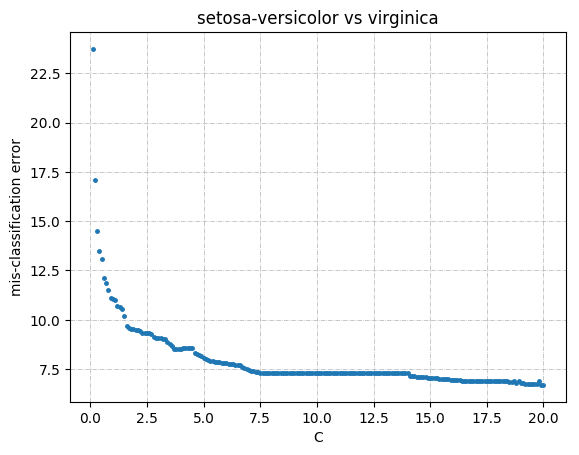

In [65]:
# misclassification error as a function of C
# or using SVM scikit and confusion matrix try to minimize # patterns

data = []

for C in range(1,201): # [0.1,30.0]
  C = C * 0.1
  wt, fxn_vals = run(X,y,C, fxn=True)
  err = hinge_loss(Xt,y,wt)
  data.append([C,err])
  if C%10 == 0: print(C)

out = np.array(data)


fig, ax = plt.subplots()
ax.plot(out[:,0],out[:,1], '.', markersize=5)
#ax.plot(out[:,0],out[:,2], '.', markersize=6, label="|w|")#, label='hinge loss obj fxn %d' % C)
ax.set_xlabel('C')
ax.set_ylabel('mis-classification error')
ax.grid(b=True, linestyle='-.', linewidth=0.5)
ax.set_title(classes)
#ax.legend()
plt.show()

2. Report your convergence criterion as part of the submission. (The majorized hinge loss soft margin SVM algorithm has no step-size parameters. It alternates between solving for (w,b) and z until convergence is reached.)



```
norm = np.linalg.norm(maj - maj_prev)    
if norm < 1e-5:
      print("converged")```

- Threshold is simillar to SciKit-Learn SVN
- maj, and maj_prev are values of Majorized objective function

2.5. Find suitable choice of C using cross validation 

Accuracy for C=0.100000 : 0.96 (+/- 0.09)
Accuracy for C=0.200000 : 0.97 (+/- 0.07)
Accuracy for C=0.300000 : 0.97 (+/- 0.07)
Accuracy for C=0.400000 : 0.97 (+/- 0.07)
Accuracy for C=0.500000 : 0.97 (+/- 0.08)
Accuracy for C=0.600000 : 0.97 (+/- 0.08)
Accuracy for C=0.700000 : 0.97 (+/- 0.08)
Accuracy for C=0.800000 : 0.97 (+/- 0.08)
Accuracy for C=0.900000 : 0.97 (+/- 0.08)
Accuracy for C=1.000000 : 0.97 (+/- 0.08)
Accuracy for C=1.100000 : 0.97 (+/- 0.08)
Accuracy for C=1.200000 : 0.97 (+/- 0.08)
Accuracy for C=1.300000 : 0.97 (+/- 0.08)
Accuracy for C=1.400000 : 0.98 (+/- 0.06)
Accuracy for C=1.500000 : 0.97 (+/- 0.07)
Accuracy for C=1.600000 : 0.97 (+/- 0.07)
Accuracy for C=1.700000 : 0.97 (+/- 0.07)
Accuracy for C=1.800000 : 0.97 (+/- 0.07)
Accuracy for C=1.900000 : 0.97 (+/- 0.07)
Accuracy for C=2.000000 : 0.97 (+/- 0.07)
Accuracy for C=2.100000 : 0.97 (+/- 0.07)
Accuracy for C=2.200000 : 0.97 (+/- 0.07)
Accuracy for C=2.300000 : 0.97 (+/- 0.07)
Accuracy for C=2.400000 : 0.97 (+/

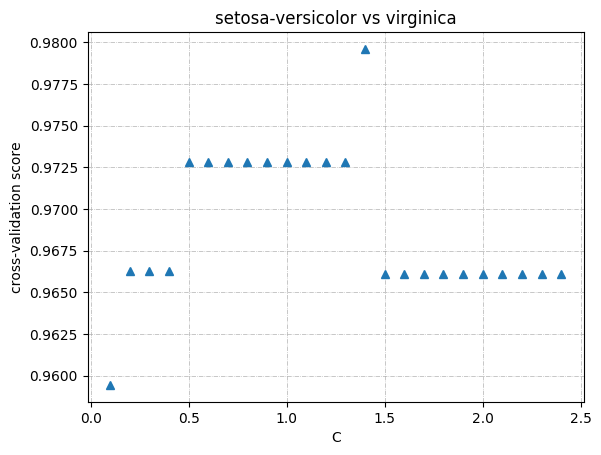

In [68]:
from sklearn.model_selection import cross_val_score
data = []

for C in range(1,25): # [0.1,30.0]
  C = C * 0.1
  clf = svm.SVC(C=C, kernel='linear')
  
  scores = cross_val_score(clf, X, y, cv=3)
  mean = scores.mean()
  std  = scores.std() * 2
  
  print("Accuracy for C=%f : %0.2f (+/- %0.2f)" % (C, mean, std))
  data.append([C,mean,std])
  
out = np.array(data)


fig, ax = plt.subplots()
ax.plot(out[:,0],out[:,1], '^', markersize=6)
#ax.plot(out[:,0],out[:,2], '.', markersize=6, label="|w|")#, label='hinge loss obj fxn %d' % C)
ax.set_xlabel('C')
ax.set_ylabel('cross-validation score')
ax.grid(b=True, linestyle='-.', linewidth=0.5)
ax.set_title(classes)
#ax.legend()
plt.show()

3. Plot the objective function values against iteration index for all 3 pairs of training sets for one suitable choice of C (which can be different for each training set pair).

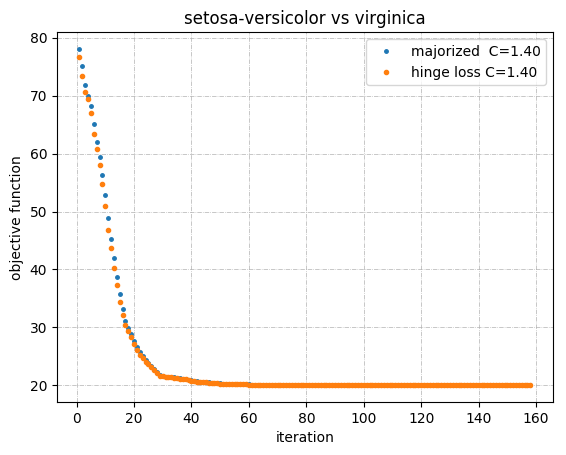

In [69]:
C = 1.4 # suitable choice of C
wt, fxn_vals = run(X,y,C, fxn=True)

fig, ax = plt.subplots()
ax.plot(fxn_vals[:,0],fxn_vals[:,1], '.', markersize=5, label='majorized  C=%.2f' % C)
ax.plot(fxn_vals[:,0],fxn_vals[:,2], '.', markersize=6, label='hinge loss C=%.2f' % C)
ax.set_xlabel('iteration')
ax.set_ylabel('objective function')
ax.set_title(classes)
ax.grid(b=True, linestyle='-.', linewidth=0.5)
ax.legend()
plt.show()

4. Compare the values of the hinge loss objective function, the weight vector and bias obtained by running the soft margin linear two class [SVM in sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) for the same training set and the same values of C. Report these in a table (using 1 for w).

In [70]:
print(classes)
print("Majorized SVM:")
wt, fxn_vals = run(X,y,C, fxn=True)
norm = np.linalg.norm(wt[0:4])
print('1/|W| = %f' % norm**(-1))
print('b = %f' % wt[-1])
print('hinge loss = %f\n' % fxn_vals[-1,-1])


print("SciKit-Learn SVM:")
w, b = sikit_svm(X,y,C)
norm = np.linalg.norm(w)
print('1/|W| = %f' % norm**(-1))
print('b = %f' % wt[-1])


wt = np.hstack((w, b.reshape(1,1))).reshape((n+1,1))
U = getu(wt)
SKmaj, SKhing = objfxn(Xt,y,C,wt,U)
print('hinge loss = %f\n' % SKhing)

setosa-versicolor vs virginica
Majorized SVM:
1/|W| = 0.306913
b = -7.756420
hinge loss = 20.062919

SciKit-Learn SVM:
1/|W| = 0.306135
b = -7.756420
hinge loss = 20.062937



In [71]:
print(C)

1.4
